In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.visualization.scatter import Scatter

from net_flow_opt.utils import components, structure, activities_duration
from net_flow_opt.system import System
from net_flow_opt.scheduler import  Plan, Activity
from net_flow_opt.discrete_model import DiscreteModel
from net_flow_opt.callbacks import TrackPerformance
from net_flow_opt.sampling import GroupingStructureSampling


Main parameters of the experiment are declared here.

In [2]:
pop_size = 150
termination = ('n_gen', 250)
seed = 1124
eps = 1e-3

The cells below repeat the experiment with a different number of resources.

In [3]:
def experiment(resources):

    system = System(structure, resources, components)

    dates = np.array([c.x_star for c in components])

    original_activities = [
        Activity(component, date, duration)
        for component, date, duration in zip(system.components, dates, activities_duration)
    ]

    original_plan = Plan(
        system=system,
        activities=original_activities
    )

    problem = DiscreteModel(
        system=system,
        original_plan=original_plan,
        resources=resources,
    )

    T = 200

    d_t = np.vstack([- dates, T - dates])

    i = np.argmax(np.abs(d_t), axis=0)

    d_t = d_t[i, np.arange(d_t.shape[1])]

    ref_point = np.array([
        system.regular_flow * T,
        np.sum([a.h(d_t[i] + eps) for i, a in enumerate(original_activities)])
    ])

    algorithm = NSGA2(
        sampling=IntegerRandomSampling(),
        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
        mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
        pop_size=pop_size,
        eliminate_duplicates=True,
        callback=TrackPerformance(ref_point=ref_point)
    )

    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=termination,
        seed=seed,
        verbose=True,
    )

    return res

In [4]:
for resources in range(3, 6):
    res = experiment(resources)

    # save data
    df = pd.DataFrame(res.opt.get("F"), columns=['IC', 'LF'])
    df.to_csv(f'../data/discrete_r{resources}.csv', index=False)

    df = pd.DataFrame(np.array(res.algorithm.callback.data['hv']), columns=['HV'])
    df.index.name = 'iter'
    df.to_csv(f'../data/discrete_hv_r{resources}.csv')

    with open(f'../data/discrete_r{resources}', 'wb') as f:
        dill.dump(res, f)

    print(f"Experiment with r={resources} completed.")

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      4 |  0.000000E+00 |  1.2000000000 |             - |             -


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


     2 |      300 |      7 |  0.000000E+00 |  0.2533333333 |  0.1745970930 |         ideal
     3 |      450 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0445698169 |             f
     4 |      600 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0491263715 |         ideal
     5 |      750 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0659803667 |         ideal
     6 |      900 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0502714443 |             f
     7 |     1050 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0848126710 |         ideal
     8 |     1200 |      9 |  0.000000E+00 |  0.000000E+00 |  0.1655792419 |         ideal


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


     9 |     1350 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0241124645 |             f
    10 |     1500 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0635677817 |         nadir
    11 |     1650 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1336904407 |         ideal
    12 |     1800 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0158494782 |             f
    13 |     1950 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0144314857 |         ideal


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    14 |     2100 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0112172848 |         ideal
    15 |     2250 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0158579216 |             f
    16 |     2400 |      9 |  0.000000E+00 |  0.000000E+00 |  4.069634E-10 |             f
    17 |     2550 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0314316181 |             f
    18 |     2700 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0088801282 |             f
    19 |     2850 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0123005043 |             f
    20 |     3000 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0127841841 |             f
    21 |     3150 |     12 |  0.000000E+00 |  0.000000E+00 |  0.2733382145 |         nadir
    22 |     3300 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0018014923 |             f
    23 |     3450 |     15 |  0.000000E+00 |  0.000000E+00 |  0.3302629159 |         nadir
    24 |     3600 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0265500911 |             f

/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    29 |     4350 |     11 |  0.000000E+00 |  0.000000E+00 |  6.664494E-10 |             f
    30 |     4500 |     11 |  0.000000E+00 |  0.000000E+00 |  6.664494E-10 |             f
    31 |     4650 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0020943777 |             f
    32 |     4800 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0020943777 |             f
    33 |     4950 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0038707009 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    34 |     5100 |     12 |  0.000000E+00 |  0.000000E+00 |  1.876954E-10 |             f
    35 |     5250 |     12 |  0.000000E+00 |  0.000000E+00 |  1.876954E-10 |             f
    36 |     5400 |     14 |  0.000000E+00 |  0.000000E+00 |  7.849260E-10 |             f
    37 |     5550 |     14 |  0.000000E+00 |  0.000000E+00 |  7.849260E-10 |             f
    38 |     5700 |     14 |  0.000000E+00 |  0.000000E+00 |  7.849260E-10 |             f
    39 |     5850 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0065547153 |             f
    40 |     6000 |     15 |  0.000000E+00 |  0.000000E+00 |  8.957283E-12 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    41 |     6150 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0122117327 |             f
    42 |     6300 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0012885369 |             f
    43 |     6450 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0034015063 |             f
    44 |     6600 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0075314260 |             f
    45 |     6750 |     18 |  0.000000E+00 |  0.000000E+00 |  7.101044E-11 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    46 |     6900 |     17 |  0.000000E+00 |  0.000000E+00 |  7.827842E-11 |             f
    47 |     7050 |     17 |  0.000000E+00 |  0.000000E+00 |  7.827842E-11 |             f
    48 |     7200 |     17 |  0.000000E+00 |  0.000000E+00 |  8.603870E-11 |             f
    49 |     7350 |     17 |  0.000000E+00 |  0.000000E+00 |  8.603870E-11 |             f
    50 |     7500 |     17 |  0.000000E+00 |  0.000000E+00 |  1.209364E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    51 |     7650 |     17 |  0.000000E+00 |  0.000000E+00 |  8.487625E-11 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    52 |     7800 |     17 |  0.000000E+00 |  0.000000E+00 |  8.531666E-11 |             f
    53 |     7950 |     17 |  0.000000E+00 |  0.000000E+00 |  8.531666E-11 |             f
    54 |     8100 |     17 |  0.000000E+00 |  0.000000E+00 |  8.531666E-11 |             f
    55 |     8250 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0049346119 |             f
    56 |     8400 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0047158821 |             f
    57 |     8550 |     17 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    58 |     8700 |     17 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    59 |     8850 |     17 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    60 |     9000 |     17 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    61 |     9150 |     17 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    62 |     9300 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0126985623 |             f
    63 |     9450 |     18 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    64 |     9600 |     18 |  0.000000E+00 |  0.000000E+00 |  7.606850E-12 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    65 |     9750 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0063894538 |             f
    66 |     9900 |     18 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    67 |    10050 |     18 |  0.000000E+00 |  0.000000E+00 |  1.758238E-10 |             f
    68 |    10200 |     18 |  0.000000E+00 |  0.000000E+00 |  1.758238E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    69 |    10350 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0036009400 |             f
    70 |    10500 |     20 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    71 |    10650 |     20 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    72 |    10800 |     21 |  0.000000E+00 |  0.000000E+00 |  4.533749E-11 |             f
    73 |    10950 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0027628831 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    74 |    11100 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0011942796 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    75 |    11250 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0068789200 |             f
    76 |    11400 |     22 |  0.000000E+00 |  0.000000E+00 |  2.059604E-10 |             f
    77 |    11550 |     22 |  0.000000E+00 |  0.000000E+00 |  2.059604E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    78 |    11700 |     22 |  0.000000E+00 |  0.000000E+00 |  2.059604E-10 |             f
    79 |    11850 |     22 |  0.000000E+00 |  0.000000E+00 |  2.059604E-10 |             f
    80 |    12000 |     22 |  0.000000E+00 |  0.000000E+00 |  2.059604E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    81 |    12150 |     22 |  0.000000E+00 |  0.000000E+00 |  2.059604E-10 |             f
    82 |    12300 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0020930764 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    83 |    12450 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0020930764 |             f
    84 |    12600 |     22 |  0.000000E+00 |  0.000000E+00 |  0.4250742655 |         nadir


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    85 |    12750 |     22 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    86 |    12900 |     22 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    87 |    13050 |     22 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    88 |    13200 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0453712455 |         ideal
    89 |    13350 |     23 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    90 |    13500 |     23 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    91 |    13650 |     24 |  0.000000E+00 |  0.000000E+00 |  8.790812E-12 |             f
    92 |    13800 |     24 |  0.000000E+00 |  0.000000E+00 |  1.107169E-11 |             f
    93 |    13950 |     24 |  0.000000E+00 |  0.000000E+00 |  1.107169E-11 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    94 |    14100 |     25 |  0.000000E+00 |  0.000000E+00 |  5.618463E-11 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


    95 |    14250 |     23 |  0.000000E+00 |  0.000000E+00 |  8.308337E-11 |             f
    96 |    14400 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0014000298 |             f
    97 |    14550 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0014000298 |             f
    98 |    14700 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0014000298 |             f
    99 |    14850 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0014609006 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   100 |    15000 |     23 |  0.000000E+00 |  0.000000E+00 |  0.2216897379 |         nadir
   101 |    15150 |     23 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   102 |    15300 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012454391 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   103 |    15450 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012674759 |             f
   104 |    15600 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012674759 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   105 |    15750 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012674761 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   106 |    15900 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012674761 |             f
   107 |    16050 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012674761 |             f
   108 |    16200 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0032612361 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   109 |    16350 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532971 |             f
   110 |    16500 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532971 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   111 |    16650 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532971 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   112 |    16800 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532974 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   113 |    16950 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532974 |             f
   114 |    17100 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532975 |             f
   115 |    17250 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532975 |             f
   116 |    17400 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532975 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   117 |    17550 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532975 |             f
   118 |    17700 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005532975 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   119 |    17850 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335389 |             f
   120 |    18000 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335389 |             f
   121 |    18150 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335389 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   122 |    18300 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335389 |             f
   123 |    18450 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335393 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   124 |    18600 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533003 |             f
   125 |    18750 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533003 |             f
   126 |    18900 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533003 |             f
   127 |    19050 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533003 |             f
   128 |    19200 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533005 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   129 |    19350 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533003 |             f
   130 |    19500 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0005533003 |             f
   131 |    19650 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335397 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   132 |    19800 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335427 |             f
   133 |    19950 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   134 |    20100 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   135 |    20250 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   136 |    20400 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   137 |    20550 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   138 |    20700 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   139 |    20850 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   140 |    21000 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   141 |    21150 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f
   142 |    21300 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0005335429 |             f

/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   143 |    21450 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0007218931 |             f
   144 |    21600 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0007218931 |             f
   145 |    21750 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0006951566 |             f
   146 |    21900 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0006951566 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   147 |    22050 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0006951566 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   148 |    22200 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0006951566 |             f
   149 |    22350 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0006951566 |             f
   150 |    22500 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0006951566 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   151 |    22650 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0031939975 |             f
   152 |    22800 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   153 |    22950 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   154 |    23100 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   155 |    23250 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   156 |    23400 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   157 |    23550 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   158 |    23700 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   159 |    23850 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   160 |    24000 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   161 |    24150 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   162 |    24300 |     26 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   163 |    24450 |     27 |  0.000000E+00 |  0.000000E+00 |  2.044016E-09 |             f
   164 |    24600 |     27 |  0.000000E+00 |  0.000000E+00 |  2.044016E-09 |             f
   165 |    24750 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   166 |    24900 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   167 |    25050 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   168 |    25200 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   169 |    25350 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   170 |    25500 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   171 |    25650 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   172 |    25800 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   173 |    25950 |     27 |  0.000000E+00 |  0.000000E+00 |  2.050945E-09 |             f
   174 |    26100 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0019911847 |             f
   175 |    26250 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0019911847 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   176 |    26400 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0019911847 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   177 |    26550 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0019911847 |             f
   178 |    26700 |     27 |  0.000000E+00 |  0.000000E+00 |  0.1179109180 |         nadir


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   179 |    26850 |     27 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   180 |    27000 |     27 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   181 |    27150 |     27 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   182 |    27300 |     27 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   183 |    27450 |     27 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   184 |    27600 |     27 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   185 |    27750 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   186 |    27900 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   187 |    28050 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   188 |    28200 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   189 |    28350 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   190 |    28500 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   191 |    28650 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   192 |    28800 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   193 |    28950 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f
   194 |    29100 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374585 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   195 |    29250 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   196 |    29400 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f
   197 |    29550 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f
   198 |    29700 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f
   199 |    29850 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   200 |    30000 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f
   201 |    30150 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   202 |    30300 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154772 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   203 |    30450 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154773 |             f
   204 |    30600 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154773 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_g

   205 |    30750 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0006154773 |             f
   206 |    30900 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   207 |    31050 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   208 |    31200 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   209 |    31350 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   210 |    31500 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   211 |    31650 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   212 |    31800 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   213 |    31950 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   214 |    32100 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   215 |    32250 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   216 |    32400 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0006374587 |             f
   217 |    32550 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0022662212 |             f
   218 |    32700 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0022662212 |             f
   219 |    32850 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0022662212 |             f
   220 |    33000 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0034936452 |             f
   221 |    33150 |     30 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   222 |    33300 |     30 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   223 |    33450 |     30 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   224 |    33600 |     30 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   225 |    33750 |     30 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   226 |    33900 |     29 |  0.000000E+00 |  0.000000E+00 |  2.613139E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   227 |    34050 |     29 |  0.000000E+00 |  0.000000E+00 |  2.613139E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   228 |    34200 |     29 |  0.000000E+00 |  0.000000E+00 |  2.613139E-10 |             f
   229 |    34350 |     29 |  0.000000E+00 |  0.000000E+00 |  2.613139E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   230 |    34500 |     29 |  0.000000E+00 |  0.000000E+00 |  2.613139E-10 |             f
   231 |    34650 |     28 |  0.000000E+00 |  0.000000E+00 |  2.733069E-10 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   232 |    34800 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0296304049 |         nadir


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   233 |    34950 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   234 |    35100 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   235 |    35250 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   236 |    35400 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   237 |    35550 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   238 |    35700 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   239 |    35850 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   240 |    36000 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   241 |    36150 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   242 |    36300 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   243 |    36450 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   244 |    36600 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   245 |    36750 |     29 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   246 |    36900 |     30 |  0.000000E+00 |  0.000000E+00 |  2.818007E-11 |             f
   247 |    37050 |     30 |  0.000000E+00 |  0.000000E+00 |  2.818007E-11 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_g

   248 |    37200 |     30 |  0.000000E+00 |  0.000000E+00 |  2.818007E-11 |             f
   249 |    37350 |     30 |  0.000000E+00 |  0.000000E+00 |  2.818007E-11 |             f


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   250 |    37500 |     30 |  0.000000E+00 |  0.000000E+00 |  2.818007E-11 |             f
Experiment with r=2 completed.


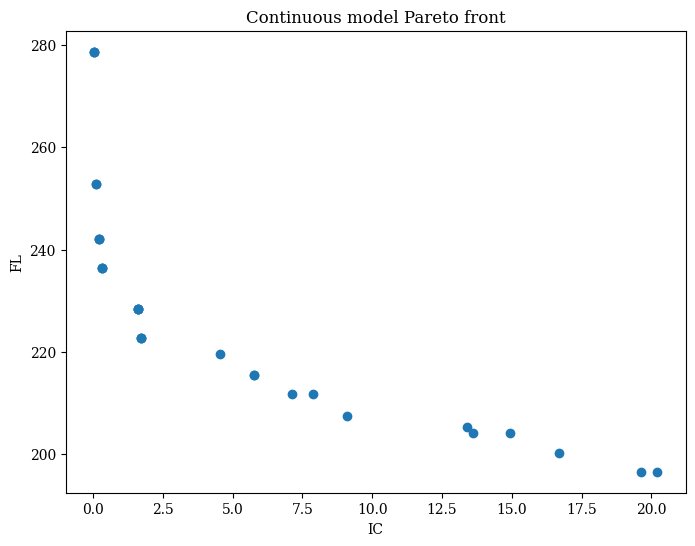

In [5]:
F = res.opt.get("F")
plot = Scatter(
    title="Continuous model Pareto front",
    labels=['IC', 'FL']
)
plot.add(F)
plot.show()

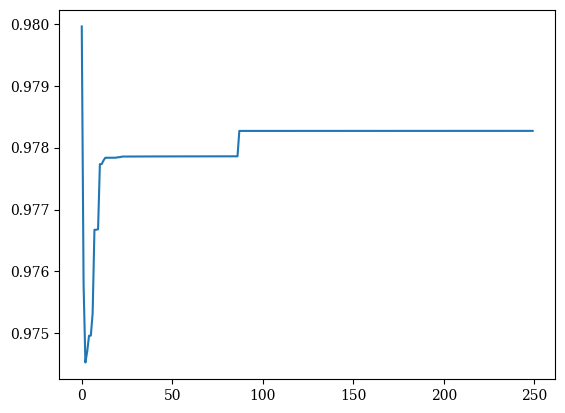

In [6]:

hv = np.array(res.algorithm.callback.data['hv'])

plt.plot(hv)